In [60]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [52]:
from pandas import read_csv
from datetime import datetime
# load data

def parse(*args): 
    return datetime.strptime(str(args[0])+ " " + str(args[1]) , '%d/%m/%Y %H:%M:%S')
dataset = read_csv('AirQualityUCI.csv',  parse_dates = [['Date', 'Time']], index_col=0, date_parser=parse)
#print( dataset.head())
#dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['CO(GT)','PT08.S1(CO)','NMHC(GT)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)','T','RH','AH'
]
dataset.index.name = 'date'
# mark all NA values with 0
#dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
#dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('AirQualClean.csv')

                     CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
date                                                                          
2004-03-11 00:00:00     1.2         1185        31       3.6            690   
2004-03-11 01:00:00     1.0         1136        31       3.3            672   
2004-03-11 02:00:00     0.9         1094        24       2.3            609   
2004-03-11 03:00:00     0.6         1010        19       1.7            561   
2004-03-11 04:00:00  -200.0         1011        14       1.3            527   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
date                                                                
2004-03-11 00:00:00       62          1462       77          1333   
2004-03-11 01:00:00       62          1453       76          1333   
2004-03-11 02:00:00       45          1579       60          1276   
2004-03-11 03:00:00     -200          1705     -200          1235   
2004-03-11 04:00:00       21    

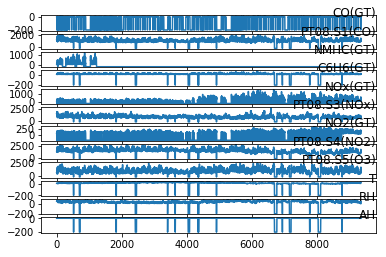

In [58]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('AirQualClean.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7,8,9,10,11,12]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [86]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i));  #      print(df.shift(-i).head())
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('AirQualClean.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#print(scaled[:5])
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
print(reframed.head())
reframed.drop(reframed.columns[[13,14,15,16,17,18,19,20,21,22,23,24]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.949505   0.618304   0.166307   0.772089   0.368683   0.156045   
2   0.948561   0.596429   0.166307   0.770952   0.361226   0.156045   
3   0.948089   0.577679   0.161267   0.767160   0.335128   0.145920   
4   0.946673   0.540179   0.157667   0.764884   0.315244   0.000000   
5   0.000000   0.540625   0.154068   0.763367   0.301160   0.131626   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)    ...      var4(t)   var5(t)  \
1   0.576483   0.512963   0.515294    0.342637    ...     0.770952  0.361226   
2   0.573361   0.511111   0.515294    0.341535    ...     0.767160  0.335128   
3   0.617066   0.481481   0.496134    0.301138    ...     0.764884  0.315244   
4   0.660770   0.000000   0.482353    0.257437    ...     0.763367  0.301160   
5   0.699965   0.433333   0.469580    0.236871    ...     0.762609  0.294946   

    var6(t)   var7(t)   var8(t)   var9(t)  var10(t)  var11(t)  var12(t)  \
1  0.156045  0.57

In [129]:
train=0.6
test=0.4
# split into train and test sets
values = reframed.values
n_train_hours = int(reframed.shape[0]*train)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1:]
test_X, test_y = test[:, :-1], test[:, -1:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
#print(train_y[:5])


((5610, 1, 13), (5610, 1), (3740, 1, 13), (3740, 1))


In [131]:
# design network
model = Sequential()
model.add(LSTM(75, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.add(Dense(1))
model.compile(loss='mae', optimizer='rmsprop')
# fit network
history = model.fit(train_X, train_y, epochs=70, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 5610 samples, validate on 3740 samples
Epoch 1/70
0s - loss: 0.6803 - val_loss: 0.1608
Epoch 2/70
0s - loss: 0.0714 - val_loss: 0.0654
Epoch 3/70
0s - loss: 0.0493 - val_loss: 0.0556
Epoch 4/70
0s - loss: 0.0337 - val_loss: 0.0442
Epoch 5/70
0s - loss: 0.0249 - val_loss: 0.0342
Epoch 6/70
0s - loss: 0.0218 - val_loss: 0.0307
Epoch 7/70
0s - loss: 0.0203 - val_loss: 0.0298
Epoch 8/70
0s - loss: 0.0197 - val_loss: 0.0283
Epoch 9/70
0s - loss: 0.0195 - val_loss: 0.0278
Epoch 10/70
0s - loss: 0.0192 - val_loss: 0.0271
Epoch 11/70
0s - loss: 0.0189 - val_loss: 0.0263
Epoch 12/70
0s - loss: 0.0188 - val_loss: 0.0257
Epoch 13/70
0s - loss: 0.0188 - val_loss: 0.0254
Epoch 14/70
0s - loss: 0.0187 - val_loss: 0.0248
Epoch 15/70
0s - loss: 0.0184 - val_loss: 0.0240
Epoch 16/70
0s - loss: 0.0182 - val_loss: 0.0238
Epoch 17/70
0s - loss: 0.0177 - val_loss: 0.0248
Epoch 18/70
0s - loss: 0.0180 - val_loss: 0.0230
Epoch 19/70
0s - loss: 0.0176 - val_loss: 0.0222
Epoch 20/70
0s - loss: 0.0178 

In [133]:
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[2]))

In [134]:
print(test_X.shape)

(3740, 1, 13)


In [135]:
# make a prediction
yhat = model.predict(test_X)
print(yhat[:5])
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_y[:,-1:])
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
print(inv_yhat[:5])
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print(inv_y[:5])
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

[[ 1.00579941]
 [ 1.00645316]
 [ 1.00114202]
 [ 0.99968338]
 [ 1.00082564]]
[[ 0.99725318]
 [ 0.99688029]
 [ 0.99657273]
 ..., 
 [ 0.99213576]
 [ 0.9915092 ]
 [ 0.99145436]]
[ 13.12887669  13.26740551  12.14197636  11.83288956  12.07493591]
[ 11.31793022  11.23891544  11.1737442   11.19145107  11.20852757]
Test RMSE: 12.208
